<a href="https://colab.research.google.com/github/BhavaniAM/TokenFlow/blob/master/inference_playground_Rerender_A_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook performs translation on key frames

In [1]:
%cd /content
!git clone --recursive https://github.com/williamyang1991/Rerender_A_Video
!sed -i 's/distributed/rank_zero/g' /content/Rerender_A_Video/deps/ControlNet/ldm/models/diffusion/ddpm.py
!pip install -q gradio xformers==0.0.20 einops blendmodes pytorch_lightning safetensors transformers open_clip_torch omegaconf
!apt -y install -qq aria2
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/PKUWilliamYang/Rerender/resolve/main/models/gmflow_sintel-0c07dcb3.pth -d /content/Rerender_A_Video/models -o gmflow_sintel-0c07dcb3.pth
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lllyasviel/ControlNet/resolve/main/models/control_sd15_canny.pth -d /content/Rerender_A_Video/models -o control_sd15_canny.pth
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lllyasviel/ControlNet/resolve/main/models/control_sd15_hed.pth -d /content/Rerender_A_Video/models -o control_sd15_hed.pth
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/stabilityai/sd-vae-ft-mse-original/resolve/main/vae-ft-mse-840000-ema-pruned.ckpt -d /content/Rerender_A_Video/models -o vae-ft-mse-840000-ema-pruned.ckpt
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Anonymous-sub/Rerender/resolve/main/models/revAnimated_v11.safetensors -d /content/Rerender_A_Video/models -o revAnimated_v11.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Anonymous-sub/Rerender/resolve/main/pexels-koolshooters-7322716.mp4 -d /content/Rerender_A_Video/data -o pexels-koolshooters-7322716.mp4
%cd /content/Rerender_A_Video

/content
Cloning into 'Rerender_A_Video'...
remote: Enumerating objects: 558, done.
remote: Counting objects: 100% (326/326), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 558 (delta 294), reused 188 (delta 188), pack-reused 232 (from 1)
Receiving objects: 100% (558/558), 9.04 MiB | 37.63 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Submodule 'deps/ControlNet' (https://github.com/lllyasviel/ControlNet.git) registered for path 'deps/ControlNet'
Submodule 'deps/ebsynth' (https://github.com/SingleZombie/ebsynth.git) registered for path 'deps/ebsynth'
Submodule 'deps/gmflow' (https://github.com/haofeixu/gmflow.git) registered for path 'deps/gmflow'
Cloning into '/content/Rerender_A_Video/deps/ControlNet'...
remote: Enumerating objects: 1356, done.        
remote: Total 1356 (delta 0), reused 0 (delta 0), pack-reused 1356 (from 1)        
Receiving objects: 100% (1356/1356), 122.40 MiB | 39.08 MiB/s, done.
Resolving deltas: 100% (599/599), done.
Cloning into

In [2]:
%cd /content/Rerender_A_Video
import argparse
import os
import random

import cv2
import einops
import numpy as np
import imageio
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from blendmodes.blend import BlendType, blendLayers
from PIL import Image
from pytorch_lightning import seed_everything
from safetensors.torch import load_file
from skimage import exposure
from IPython.display import display

import src.import_util
from deps.ControlNet.annotator.canny import CannyDetector
from deps.ControlNet.annotator.hed import HEDdetector
from deps.ControlNet.annotator.util import HWC3, resize_image
from deps.ControlNet.cldm.cldm import ControlLDM
from deps.ControlNet.cldm.model import create_model, load_state_dict
from deps.gmflow.gmflow.gmflow import GMFlow
from flow.flow_utils import get_warped_and_mask
from src.config import RerenderConfig
from src.controller import AttentionControl
from src.ddim_v_hacked import DDIMVSampler
from src.img_util import find_flat_region, numpy2tensor
from src.video_util import frame_to_video, get_fps, prepare_frames

/content/Rerender_A_Video


/usr/local/lib/python3.11/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

logging improved.


In [3]:
blur = T.GaussianBlur(kernel_size=(9, 9), sigma=(18, 18))
totensor = T.PILToTensor()

def setup_color_correction(image):
    correction_target = cv2.cvtColor(np.asarray(image.copy()),
                                     cv2.COLOR_RGB2LAB)
    return correction_target

def apply_color_correction(correction, original_image):
    image = Image.fromarray(
        cv2.cvtColor(
            exposure.match_histograms(cv2.cvtColor(np.asarray(original_image),
                                                   cv2.COLOR_RGB2LAB),
                                      correction,
                                      channel_axis=2),
            cv2.COLOR_LAB2RGB).astype('uint8'))

    image = blendLayers(image, original_image, BlendType.LUMINOSITY)

    return image

In [4]:
# load optical flow model
flow_model = GMFlow(
    feature_channels=128,
    num_scales=1,
    upsample_factor=8,
    num_head=1,
    attention_type='swin',
    ffn_dim_expansion=4,
    num_transformer_layers=6,
).to('cuda')

checkpoint = torch.load('models/gmflow_sintel-0c07dcb3.pth', map_location=lambda storage, loc: storage)
weights = checkpoint['model'] if 'model' in checkpoint else checkpoint
flow_model.load_state_dict(weights, strict=False)
flow_model.eval()

GMFlow(
  (backbone): CNNEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      

In [5]:
control_type = 'canny'
canny_low = 50
canny_high = 100
sd_model = './models/revAnimated_v11.safetensors'

inner_strength = 0.9
cross_period = [0, 1]    # cross-frame attention
warp_period = [0, 0.1]   # shape-aware cross-frame fusion
mask_period = [0.5, 0.8] # pixel-aware cross-frame fusion
ada_period = [0.8, 1]    # adaptive color adjustment

In [6]:
# Load SD and controlnet models
if control_type == 'HED':
    detector = HEDdetector()
elif control_type == 'canny':
    canny_detector = CannyDetector()
    def apply_canny(x):
        return canny_detector(x, canny_low, canny_high)
    detector = apply_canny

model: ControlLDM = create_model(
    './deps/ControlNet/models/cldm_v15.yaml').cpu()
if control_type == 'HED':
    model.load_state_dict(
        load_state_dict('./models/control_sd15_hed.pth', location='cuda'), strict=False)
elif control_type == 'canny':
    model.load_state_dict(load_state_dict('./models/control_sd15_canny.pth', location='cuda'), strict=False)
model = model.cuda()

# load LoRA or finetuned model
model_ext = os.path.splitext(sd_model)[1]
if model_ext == '.safetensors':
    model.load_state_dict(load_file(sd_model), strict=False)
elif model_ext == '.ckpt' or model_ext == '.pth':
    model.load_state_dict(torch.load(sd_model)['state_dict'], strict=False)

# load VAE
model.first_stage_model.load_state_dict(torch.load('./models/vae-ft-mse-840000-ema-pruned.ckpt')['state_dict'], strict=False)

# get the sampler
ddim_v_sampler = DDIMVSampler(model)

# get the temporal consistency controller
controller = AttentionControl(0.9, mask_period, cross_period, ada_period, warp_period)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [7]:
seed = 0
ddim_steps = 20
filename = './data/pexels-koolshooters-7322716.mp4'
savename = './result.mp4'
scale = 7.5
image_resolution = 512
num_samples = 1

prompt = 'a beautiful woman in CG style'
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

control_strength = [0.7] * 13
model.control_scales = control_strength
keyframe_count = 11
interval = 10
strength = 0.75
strength = 1 - strength
color_preserve = True
style_update_freq = 1
firstx0 = True # warp the first frame or previous frame in shape-aware cross-frame fusion
pixelfusion = True # whether using pixel-aware cross-frame fusion
smooth_boundary = True # smooth the fusion boundary to avoid artifacts
mask_strength = 0.5 # smooth the fusion region to avoid artifacts

In [8]:
video_cap = cv2.VideoCapture(filename)
keyframe_count = min(keyframe_count, (video_cap.get(cv2.CAP_PROP_FRAME_COUNT)-2) // interval)
fps = max(video_cap.get(cv2.CAP_PROP_FPS)//interval, 1)

# first key frame

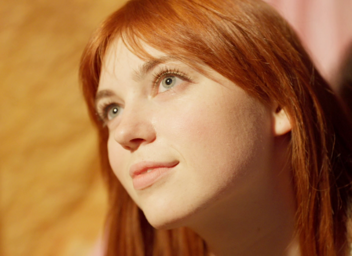

processing key frame #000...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


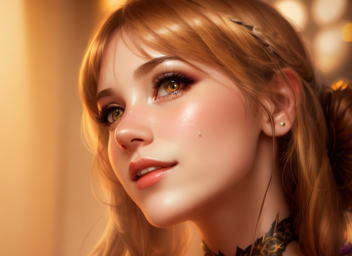

In [9]:
with torch.no_grad():
    success, frame = video_cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = resize_image(HWC3(frame), image_resolution)
    H, W, C = img.shape
    display(Image.fromarray(img).resize((W//2,H//2)))
    print('processing key frame #%03d...'%(0))

    x0_strength = strength if color_preserve else -1
    img_ = numpy2tensor(img)
    encoder_posterior = model.encode_first_stage(img_.cuda())
    x0 = model.get_first_stage_encoding(encoder_posterior).detach()
    detected_map = detector(img)
    detected_map = HWC3(detected_map)
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()
    cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
    un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
    shape = (4, H // 8, W // 8)

    controller.set_task('initfirst')
    seed_everything(seed)
    samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=0,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond,
                                                 controller = controller,
                                                 x0=x0, strength=x0_strength)
    x_samples = model.decode_first_stage(samples)
    x_samples_np = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    if not color_preserve:
        color_corrections = setup_color_correction(Image.fromarray(x_samples_np[0]))
        img_ = apply_color_correction(color_corrections, Image.fromarray(img))
        img_ = totensor(img_).unsqueeze(0)[:,:3] / 127.5 - 1
        encoder_posterior = model.encode_first_stage(img_.cuda())
        x0 = model.get_first_stage_encoding(encoder_posterior).detach()

        controller.set_task('initfirst')
        seed_everything(seed)
        samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=0,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond,
                                                     controller = controller,
                                                     x0=x0, strength=strength)
        x_samples = model.decode_first_stage(samples)
        x_samples_np = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

    pre_result = x_samples
    pre_img = img
    first_result = pre_result
    first_img = pre_img
    display(Image.fromarray(x_samples_np[0]).resize((W//2,H//2)))

# other key frames

processing key frame #001...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


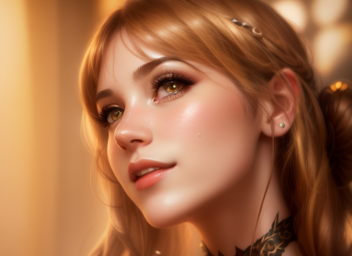

processing key frame #002...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


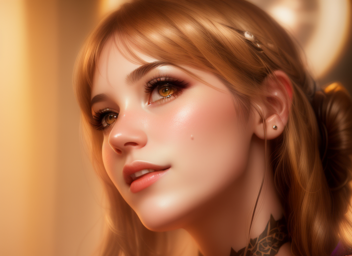

processing key frame #003...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


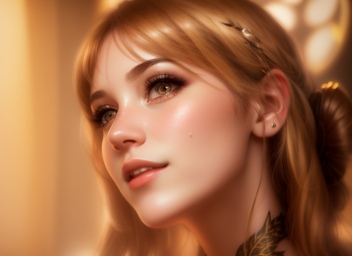

processing key frame #004...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


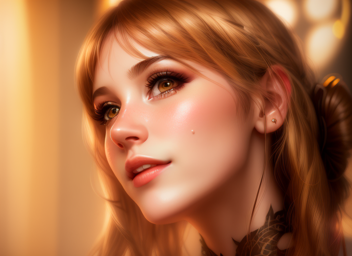

processing key frame #005...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


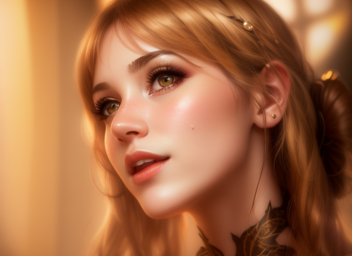

processing key frame #006...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


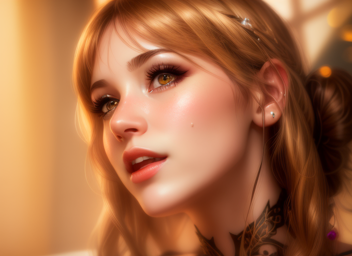

processing key frame #007...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


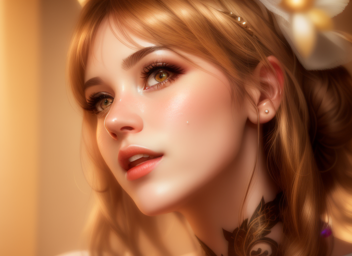

processing key frame #008...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


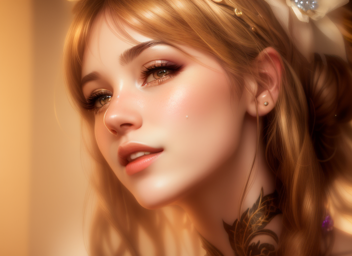

processing key frame #009...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


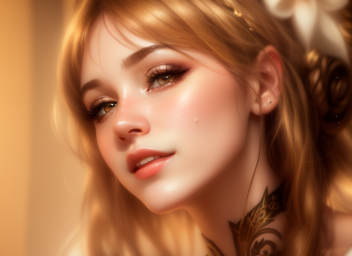

processing key frame #010...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


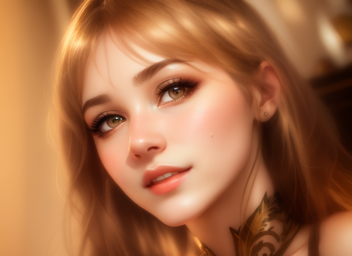

processing key frame #011...


INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]
INFO:lightning_fabric.utilities.seed:Seed set to 0


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


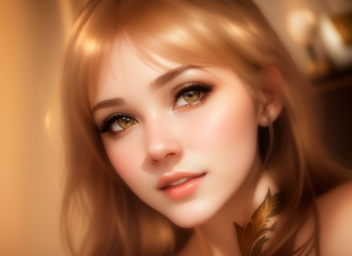

In [10]:
results = []
for i in range(keyframe_count):
    success, frame = video_cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print('processing key frame #%03d...'%(i+1))
    img = resize_image(HWC3(frame), image_resolution)
    for _ in range(interval-1):
        success, frame = video_cap.read()

    if color_preserve:
        img_ = numpy2tensor(img)
    else:
        img_ = apply_color_correction(color_corrections, Image.fromarray(img))
        img_ = totensor(img_).unsqueeze(0)[:,:3] / 127.5 - 1
    encoder_posterior = model.encode_first_stage(img_.cuda())
    x0 = model.get_first_stage_encoding(encoder_posterior).detach()

    detected_map = detector(img)
    detected_map = HWC3(detected_map)
    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()
    cond["c_concat"] = [control]
    un_cond["c_concat"] = [control]

    image1 = torch.from_numpy(pre_img).permute(2, 0, 1).float()
    image2 = torch.from_numpy(img).permute(2, 0, 1).float()
    warped_pre, bwd_occ_pre, bwd_flow_pre = get_warped_and_mask(flow_model, image1, image2, pre_result, False)
    blend_mask_pre = blur(F.max_pool2d(bwd_occ_pre, kernel_size=9, stride=1, padding=4))
    blend_mask_pre = torch.clamp(blend_mask_pre + bwd_occ_pre, 0, 1)

    image1 = torch.from_numpy(first_img).permute(2, 0, 1).float()
    warped_0, bwd_occ_0, bwd_flow_0 = get_warped_and_mask(flow_model, image1, image2, first_result, False)
    blend_mask_0 = blur(F.max_pool2d(bwd_occ_0, kernel_size=9, stride=1, padding=4))
    blend_mask_0 = torch.clamp(blend_mask_0 + bwd_occ_0, 0, 1)

    if firstx0:
        mask = 1 - F.max_pool2d(blend_mask_0, kernel_size=8)
        controller.set_warp(F.interpolate(bwd_flow_0 / 8.0, scale_factor=1./8, mode='bilinear'), mask)
    else:
        mask = 1 - F.max_pool2d(blend_mask_pre, kernel_size=8)
        controller.set_warp(F.interpolate(bwd_flow_pre / 8.0, scale_factor=1./8, mode='bilinear'), mask)

    controller.set_task('keepx0, keepstyle', 1)
    seed_everything(seed)
    samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=0,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond,
                                                 controller = controller,
                                                 x0=x0, strength=strength)
    direct_result = model.decode_first_stage(samples)

    if not pixelfusion:
        pre_result = direct_result
        pre_img = img
        x_samples_np = (einops.rearrange(direct_result, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        results+= [x_samples_np[0]]
        display(Image.fromarray(x_samples_np[0]).resize((W//2,H//2)))
        continue

    blend_results = (1-blend_mask_pre) * warped_pre + blend_mask_pre * direct_result
    blend_results = (1-blend_mask_0) * warped_0 + blend_mask_0 * blend_results

    bwd_occ = 1-torch.clamp(1-bwd_occ_pre + 1-bwd_occ_0, 0, 1)
    blend_mask= blur(F.max_pool2d(bwd_occ, kernel_size=9, stride=1, padding=4))
    blend_mask = 1-torch.clamp(blend_mask + bwd_occ, 0, 1)

    encoder_posterior = model.encode_first_stage(blend_results)
    xtrg = model.get_first_stage_encoding(encoder_posterior).detach()
    blend_results_rec = model.decode_first_stage(xtrg)
    encoder_posterior = model.encode_first_stage(blend_results_rec)
    xtrg_rec = model.get_first_stage_encoding(encoder_posterior).detach()
    xtrg_ = (xtrg + 1 * (xtrg - xtrg_rec))
    blend_results_rec_new = model.decode_first_stage(xtrg_)
    tmp = (abs(blend_results_rec_new-blend_results).mean(dim=1, keepdims=True)>0.25).float()
    mask_x = F.max_pool2d((F.interpolate(tmp, scale_factor=1/8., mode='bilinear')>0).float(), kernel_size=3, stride=1, padding=1)

    mask = (1 - F.max_pool2d(1-blend_mask, kernel_size=8))
    if smooth_boundary:
        noise_rescale = find_flat_region(mask)
    else:
        noise_rescale = torch.ones_like(mask)
    masks = []
    for i in range(ddim_steps):
        if i <= ddim_steps * mask_period[0] or i >= ddim_steps * mask_period[1]:
            masks += [None]
        else:
            masks += [mask * mask_strength]
    xtrg = (xtrg + (1-mask_x) * (xtrg - xtrg_rec)) * mask

    tasks = 'keepstyle, keepx0'
    if not firstx0:
        tasks += ', updatex0'
    if i % style_update_freq == 0:
        tasks += ', updatestyle'
    controller.set_task(tasks, 1)

    seed_everything(seed)
    samples, intermediates = ddim_v_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=0,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond,
                                                 controller = controller,
                                                 x0=x0, strength=strength,
                                                 xtrg=xtrg, mask=masks, noise_rescale=noise_rescale)
    x_samples = model.decode_first_stage(samples)
    pre_result = x_samples
    pre_img = img

    x_samples_np = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    results+= [x_samples_np[0]]
    display(Image.fromarray(x_samples_np[0]).resize((W//2,H//2)))

In [11]:
imageio.mimsave(savename, results, fps=fps)